In [2]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 
import pickle

import SessionTools.two_photon as st2p

In [ ]:
# access data in downloads folder
data_directory = 'LineScan-04082025-1531-fly4-036'

basedir = pathlib.PurePath(f'/Users/lilynguyen/Downloads/{data_directory}')
basename_input = pathlib.Path(basedir.joinpath(data_directory))
metadata = st2p.preprocessing_tools.bruker_metadata.read(basename_input)

In [ ]:
# access data on hard drive
microscope = "Galadriel"
effector = "ASAP7y_jrGECO1a"
driver = "ER4d-split"
date_fly = "250417_fly6"
data_directory = 'fly6-glom-l1-2-017'

basedir = pathlib.PurePath(f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/{data_directory}')
basename_input = pathlib.Path(basedir.joinpath(data_directory))
metadata = st2p.preprocessing_tools.bruker_metadata.read(basename_input)

In [ ]:
# reformat tiffs
tiff_data = st2p.preprocessing_tools.tiff_tools.read_linescan(basename_input, metadata['linescan_size'])

(2, 2, 8192, 512)


In [ ]:
# save tiff as hdf5 file
data_dict = tiff_data
h5name = f'/Volumes/2p_data/{microscope}/{effector}/{driver}/{date_fly}/analysis/tiffs/{data_directory}.hdf5'

if not os.path.exists(h5name):
    f = h5py.File(h5name, 'w')
    for key in data_dict:
        dset = f.create_dataset(key, data=data_dict[key])
    f.close()

# # read hdf5 file
# f = h5py.File(h5name, 'r')
# f.get('Ch1')

In [ ]:
# read in voltage csv
voltage_recording_csv = str(basename_input) + f'_Cycle00001_VoltageRecording_001.csv'
df = pd.read_csv(voltage_recording_csv)

# define csv columns as variables
voltage_time = df['Time(ms)']

if ' Arena DAC1' in df.columns:
    arena_loc = df[' Arena DAC1']
    arena_scene = df[' Arena DAC2']
elif ' Arena DAC' in df.columns:
    arena_loc = df[' Arena DAC']

# downsample 

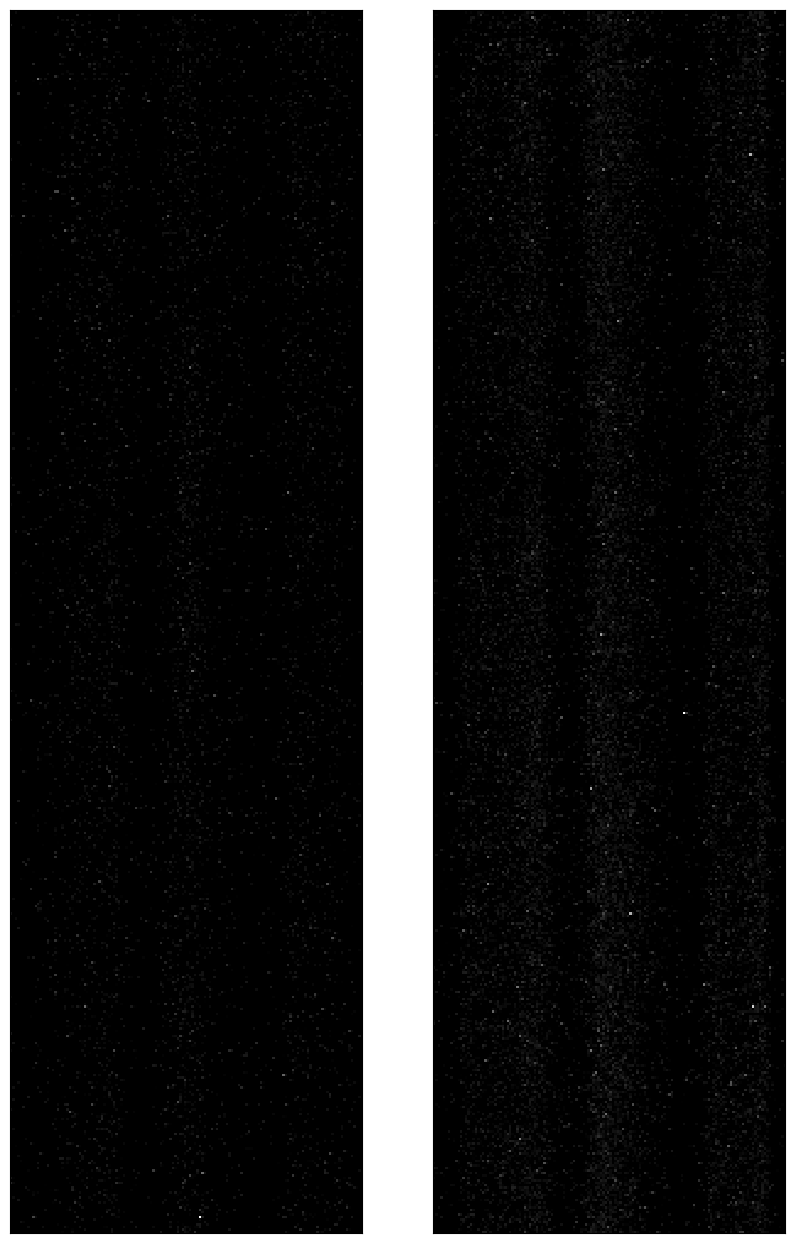

In [5]:
# plot first 500 lines from each channel
fig, ax = plt.subplots(1, len(tiff_data.keys()), figsize=(10,20))

for i, c in enumerate(tiff_data.keys()):
    ax[i].imshow(tiff_data[c][0:500], cmap='Greys_r', interpolation='nearest')
    ax[i].set_yticks([])
    ax[i].set_xticks([])

In [8]:
# function for getting the mean across y values
def get_mean_f(np_arrays):
    return np.mean(np_arrays, axis=0)

In [6]:
asap_array = tiff_data['Ch2']
geco_array = tiff_data['Ch1']

In [280]:
np.shape(asap_array)

(18408, 294)

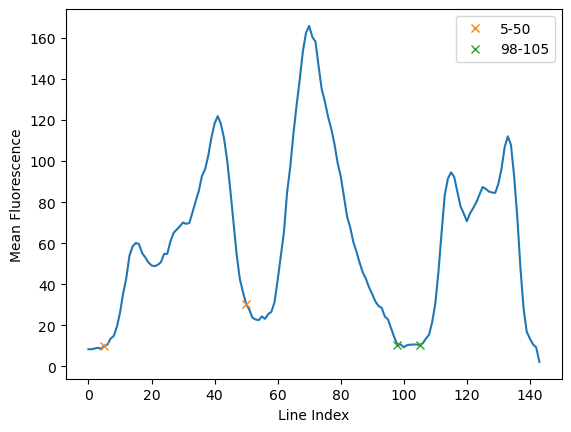

In [9]:
# average fluorescence from all line scans and plot to find glomeruli area
mean_f = get_mean_f(asap_array)

glom_start = 5
glom_end = 50

not_glom_start = 98
not_glom_end = 105

plt.plot(range(len(mean_f)), mean_f, label='_nolegend_')
plt.plot([glom_start, glom_end], mean_f[[glom_start, glom_end]], "x")
plt.plot([not_glom_start, not_glom_end], mean_f[[not_glom_start, not_glom_end]], "x")
plt.ylabel('Mean Fluorescence')
plt.xlabel('Line Index')
plt.legend([f'{glom_start}-{glom_end}', f'{not_glom_start}-{not_glom_end}'])
plt.show()

In [10]:
# create an array with the average fluorescence of the ROI during each line scan
glom_fluor = []
for idx, y in enumerate(asap_array):
    glom_fluor.append(asap_array[idx][glom_start:glom_end].mean()) # could make for loop to iterate through multiple ROIs
glom_fluor = np.array(glom_fluor)

In [14]:
# create an array with the average fluorescence of the ROI during each line scan
glom_fluor_red = []
for idx, y in enumerate(geco_array):
    glom_fluor_red.append(geco_array[idx][glom_start:glom_end].mean()) # could make for loop to iterate through multiple ROIs
glom_fluor_red = np.array(glom_fluor_red)

In [11]:
not_glom_fluor = []
for idx, y in enumerate(asap_array):
    not_glom_fluor.append(asap_array[idx][not_glom_start:not_glom_end].mean()) # could make for loop to iterate through multiple ROIs
not_glom_fluor = np.array(not_glom_fluor)

In [12]:
glom_fluor_corr = glom_fluor - not_glom_fluor

In [34]:
metadata['linescan_size']

{'frames': 3,
 'channels': 2,
 'y_px_frame': 8192,
 'x_px_line': 144,
 'y_px_last_frame': 2608,
 'scan_line_period': 0.003159}

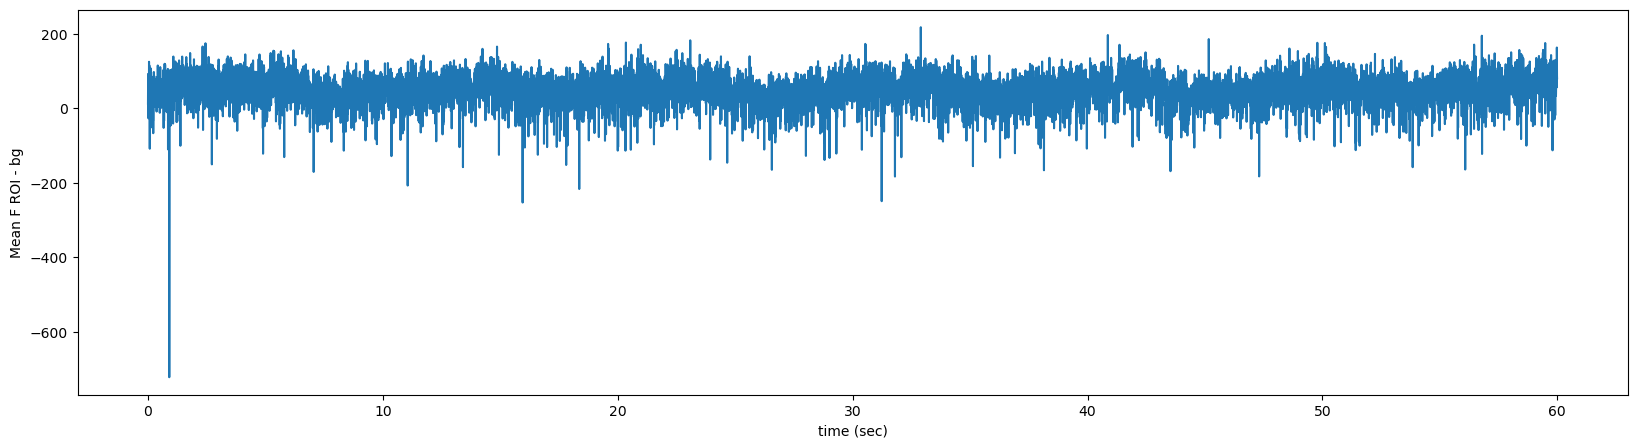

In [17]:
# plot raw fluorescence
end_time = ((metadata['linescan_size']['y_px_frame'] * metadata['linescan_size']['frames']) - (metadata['linescan_size']['y_px_frame'] - metadata['linescan_size']['y_px_last_frame'])) * metadata['linescan_size']['scan_line_period']
time = np.arange(0, end_time, metadata['linescan_size']['scan_line_period'])

plt.figure(figsize=(20, 5))
plt.plot(time[0:-1], glom_fluor_corr)
plt.ylabel('Mean F ROI - bg')
plt.xlabel('time (sec)')
plt.show()

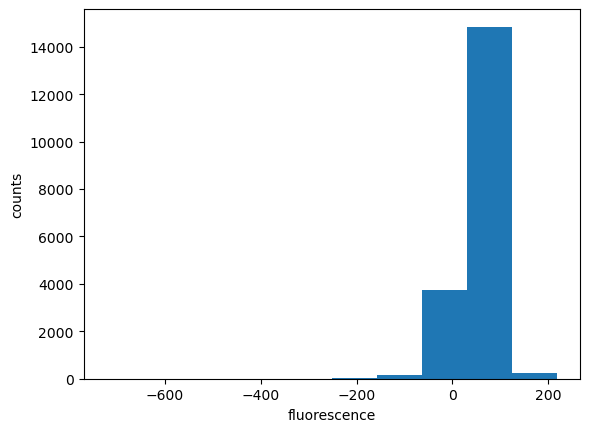

In [13]:
# plot fluorescence distribution
plt.hist(glom_fluor_corr)
plt.ylabel('counts')
plt.xlabel('fluorescence')
plt.show()

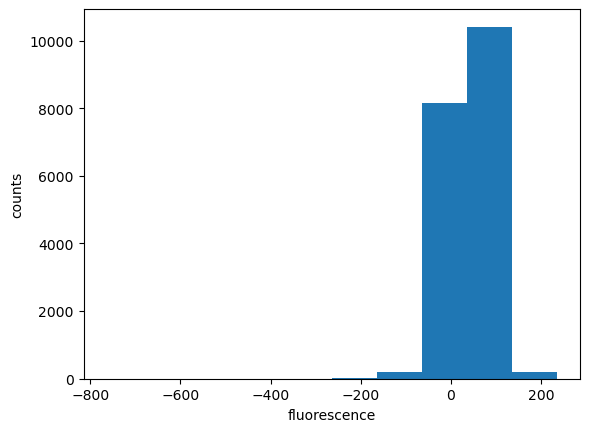

In [15]:
# plot fluorescence distribution
glom_fluor_red_corr = glom_fluor_red - not_glom_fluor

plt.hist(glom_fluor_red_corr)
plt.ylabel('counts')
plt.xlabel('fluorescence')
plt.show()

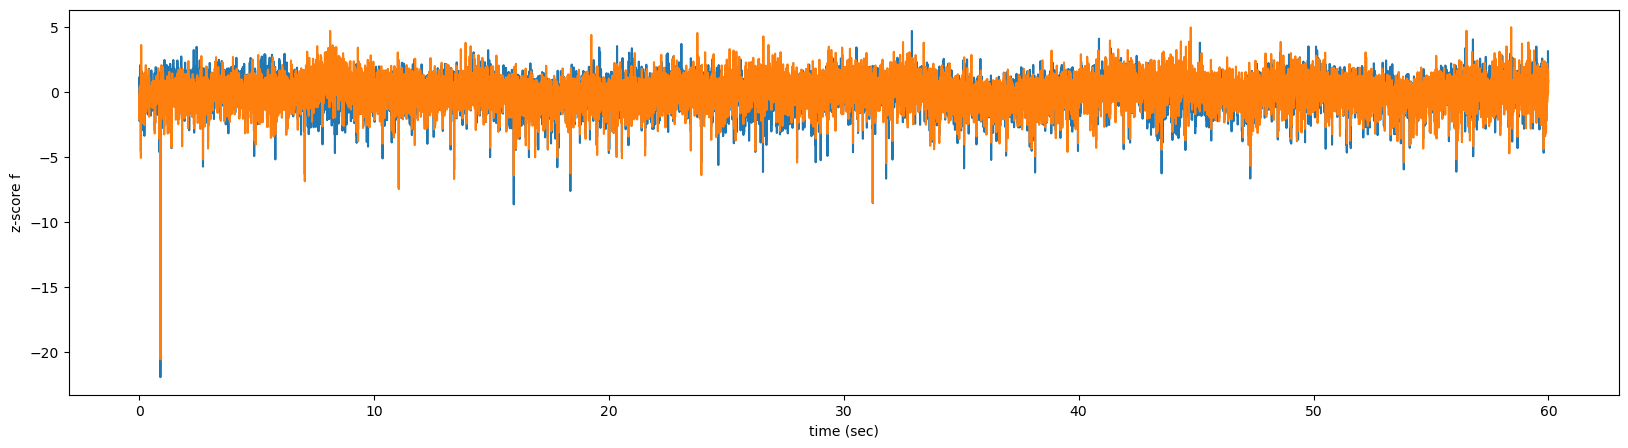

In [18]:
# z-scored fluorescence
dff_glom = sp.stats.zscore(glom_fluor_corr)
dff_red_glom = sp.stats.zscore(glom_fluor_red_corr)

plt.figure(figsize=(20, 5))
plt.plot(time[0:-1], dff_glom)
plt.plot(time[0:-1], dff_red_glom)
plt.ylabel('z-score f')
plt.xlabel('time (sec)')
plt.show()

In [35]:
dff_glom = glom_fluor_corr #+ glom_fluor_red_corr

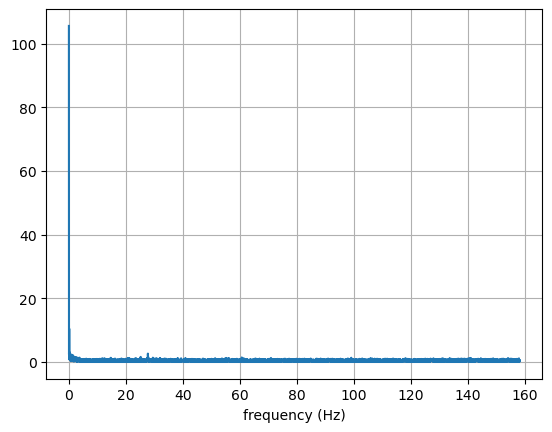

In [36]:
# plot frequencies
from scipy.fft import fft, fftfreq
# Number of sample points
N = len(dff_glom)
# sample spacing
T = metadata['linescan_size']['scan_line_period']
x = time[0:-1]
y = dff_glom
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.xlim(0, 50)
plt.xlabel('frequency (Hz)')
plt.grid()
plt.show()

In [37]:
# low pass from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
def butter_lowpass(cutoff, fs, order=5):
    return sp.signal.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sp.signal.lfilter(b, a, data)
    return y

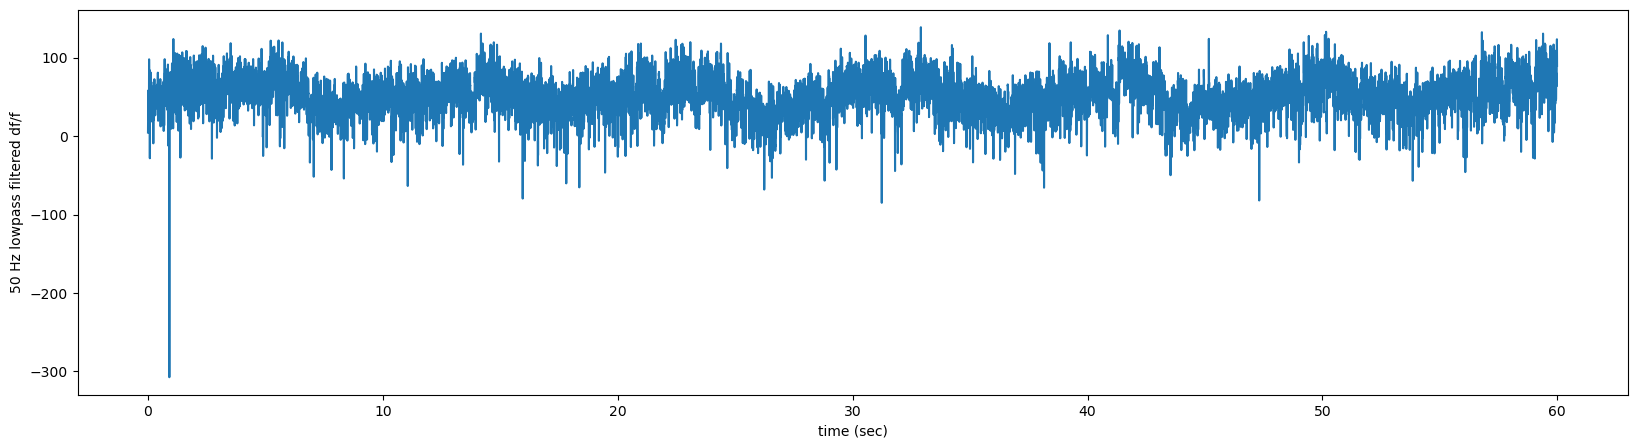

In [38]:
# lowpass filter data
cutoff = 50 # Hz
lowpass = butter_lowpass_filter(dff_glom, cutoff, 1/metadata['linescan_size']['scan_line_period'], 1)

plt.figure(figsize=(20, 5))
plt.plot(time[0:-1], lowpass)
plt.xlabel('time (sec)')
plt.ylabel(f'{cutoff} Hz lowpass filtered df/f')
plt.show()

In [ ]:
# read in voltage csv
voltage_recording_csv = str(basename_input) + f'_Cycle00001_VoltageRecording_001.csv'
df = pd.read_csv(voltage_recording_csv)

# define csv columns as variables
voltage_time = df['Time(ms)']

if ' Arena DAC1' in df.columns:
    arena_loc = df[' Arena DAC1']
    arena_scene = df[' Arena DAC2']
elif ' Arena DAC' in df.columns:
    arena_loc = df[' Arena DAC']

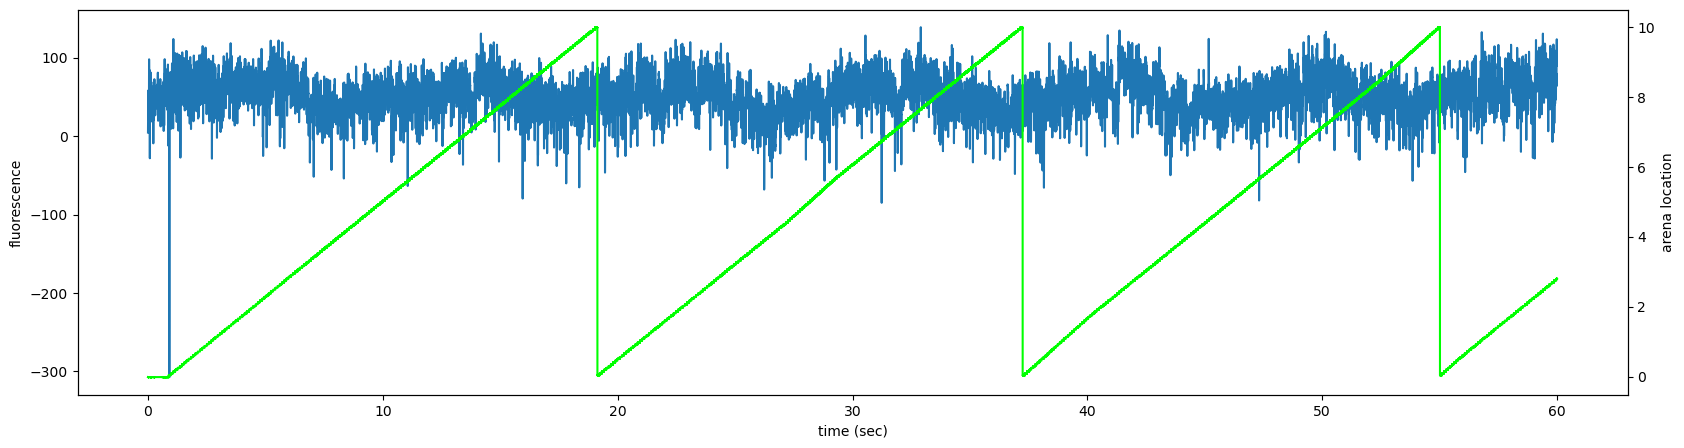

In [39]:
# plot imaging data vs arena location
plot_data = lowpass

fig, ax1 = plt.subplots(figsize=(20, 5))
ax2 = ax1.twinx()

ax1.plot(time[0:-1], plot_data)
ax1.set_xlabel('time (sec)')
ax1.set_ylabel('fluorescence')
ax2.plot(voltage_time/1000, arena_loc, color='lime')
ax2.set_ylabel('arena location')

plt.show()

In [25]:
# functions for aligning data
def make_periodic(array):
    if array.any():
        sorted = np.sort(array)
        return np.linspace(sorted[0], sorted[-1], len(sorted)).round().astype(int)
    else:
        return np.empty((0,0))

def align_data(data, starts, ends):
    if starts.any():
        rows, columns = len(starts), int(np.unique(ends-starts)[0])
        aligned_matrix = np.empty((rows, columns))
        for idx, n in enumerate(starts):
            aligned_matrix[idx,:] = data[int(n):int(ends[idx])]
        return aligned_matrix
    else:
        return np.empty((0,0))

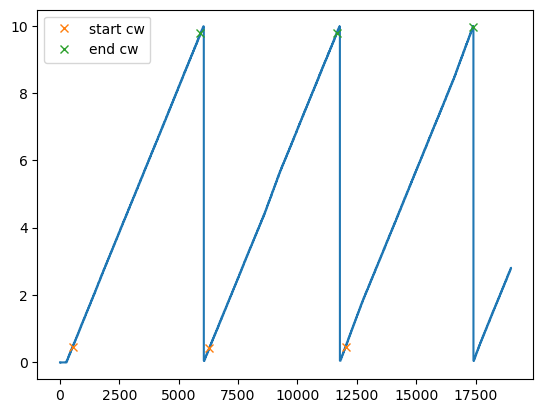

In [26]:
# interpolate voltage recording data
total_samples = len(arena_loc)
interp_pts = metadata['linescan_size']['scan_line_period'] / (voltage_time[1]/1000)

xvals = np.arange(0, total_samples, interp_pts)
arena_interp = np.interp(xvals, np.linspace(0, total_samples, total_samples), arena_loc)
interp_time = np.interp(xvals, np.linspace(0, total_samples, total_samples), voltage_time)/1000
# plt.plot(interp_time, arena_interp, '.-')
# plt.show()


# round values to integers
rounded = arena_interp.round()
# plt.plot(rounded, '.-')
# plt.show()


# determine peaks in arena location
min_distance = 0.5 / metadata['linescan_size']['scan_line_period'] # num samples in 0.5 sec
arena_peaks, properties = sp.signal.find_peaks(rounded, height=(10, None), distance=min_distance, prominence=(None, None))
# plt.plot(arena_interp)
# plt.plot(arena_peaks, arena_interp[arena_peaks], "x")
# plt.plot(properties['left_bases'], arena_interp[properties['left_bases']],"x")
# plt.plot(properties['right_bases'], arena_interp[properties['right_bases']],"x")
# plt.ylabel('Arena angle')
# plt.xlabel('sample')
# plt.show()


# sort cw and ccw rotations
peak_right_diff = properties['right_bases'] - arena_peaks
pos_change_arena = np.where(peak_right_diff > min_distance, 0, 1).astype(bool)


# define start and end for cw and ccw rotations
pos_start, pos_peaks = properties['left_bases'][pos_change_arena], arena_peaks[pos_change_arena]
neg_peaks, neg_end = arena_peaks[~pos_change_arena], properties['right_bases'][~pos_change_arena]

plt.plot(arena_interp, label='_nolegend_')

# make starts/ends at regular intervals and plot results
pos_start = make_periodic(pos_start)
if pos_start.any():
    pos_peaks = pos_start + (pos_peaks[0] - pos_start[0])
    pos_peaks = pos_peaks.astype(int)
    if pos_peaks[-1] > len(arena_interp):
        pos_start = pos_start[:-1]
        pos_peaks = pos_peaks[:-1]
    plt.plot(pos_start, arena_interp[pos_start], 'x')
    plt.plot(pos_peaks, arena_interp[pos_peaks], 'x')

neg_peaks = make_periodic(neg_peaks)
if neg_peaks.any():
    neg_end = neg_peaks + (neg_end[0] - neg_peaks[0])
    neg_end = neg_end.astype(int)
    if neg_end[-1] > len(arena_interp):
        neg_peaks = neg_peaks[:-1]
        neg_end = neg_end[:-1]
    plt.plot(neg_peaks, arena_interp[neg_peaks], 'x')
    plt.plot(neg_end, arena_interp[neg_end], 'x')

plt.legend(['start cw', 'end cw', 'start ccw', 'end ccw'])
plt.show()

In [27]:
aligned_responses = {}
aligned_responses['pos_response'] = align_data(plot_data, pos_start, pos_peaks)
aligned_responses['neg_response'] = align_data(plot_data, neg_peaks, neg_end)

aligned_arena = {}
aligned_arena['pos_response'] = align_data(arena_interp, pos_start, pos_peaks)
aligned_arena['neg_response'] = align_data(arena_interp, neg_peaks, neg_end)

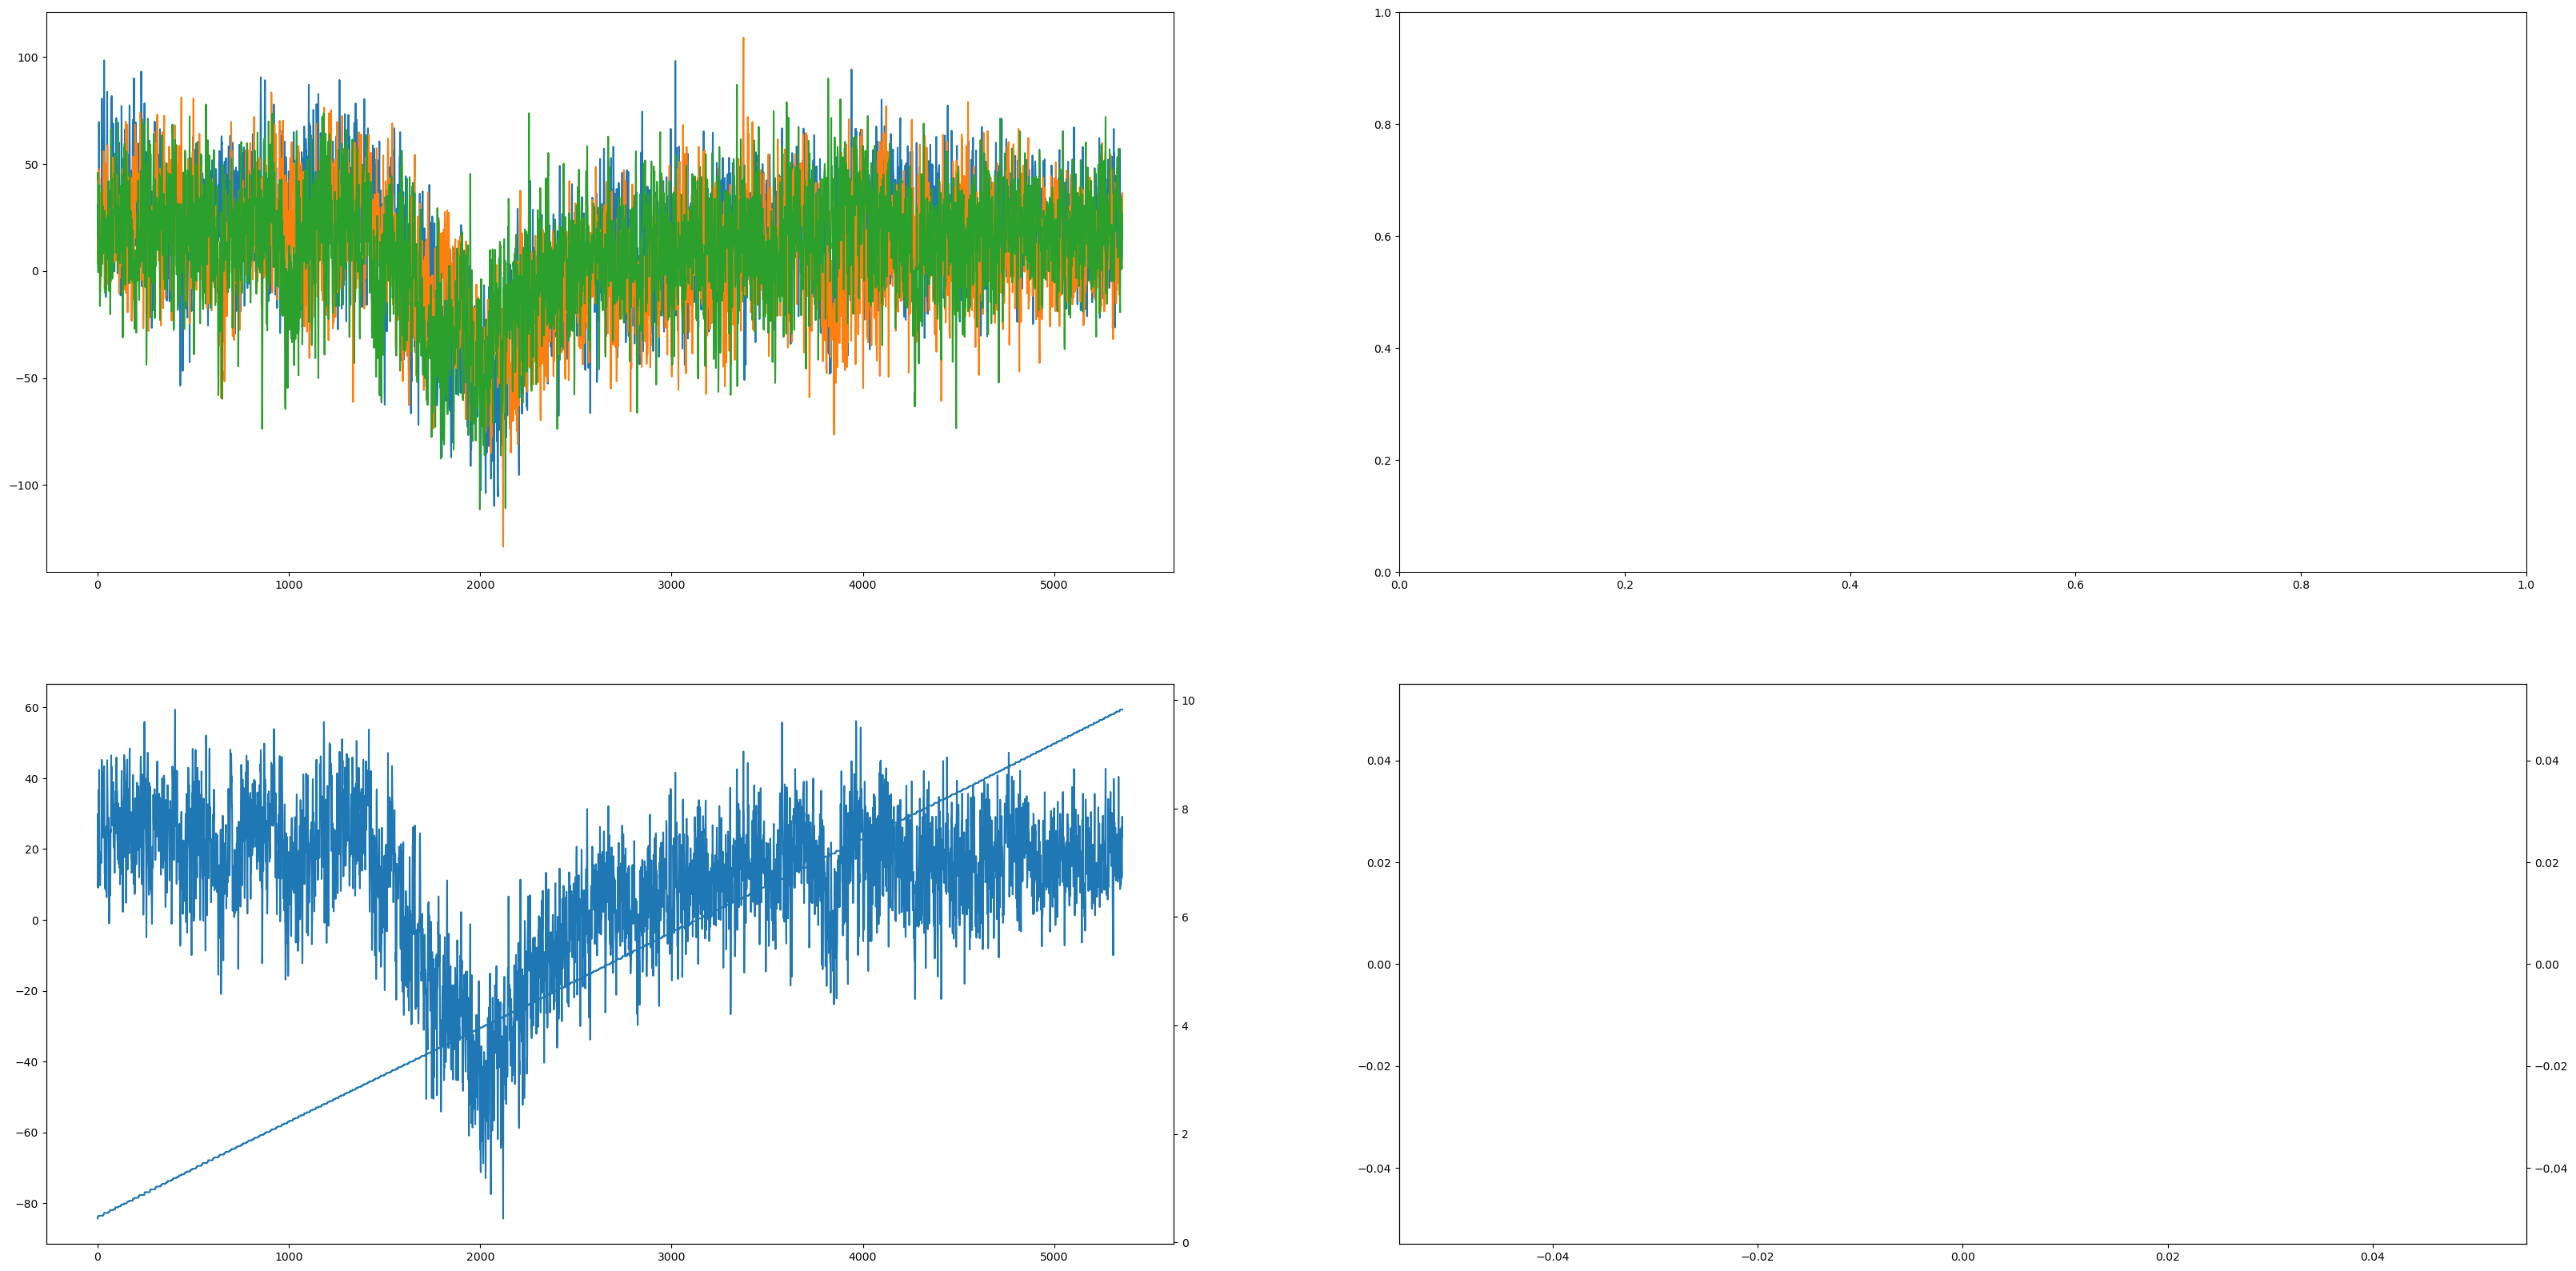

In [33]:
fig, ax1 = plt.subplots(len(aligned_responses), 2, figsize=(40, 20))

for idx, key in enumerate(aligned_responses):
    for l in aligned_responses[key]:
        ax1[0, idx].plot(l)
    ax1[1, idx].plot(np.mean(aligned_responses[key], 0))
    ax2 = ax1[1, idx].twinx()
    ax2.plot(np.mean(aligned_arena[key], 0))

plt.show()